In [4]:
import numpy as np
from scipy.stats import norm, expon, uniform
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()

import tensorflow_probability as tfp

%matplotlib inline

tfd = tfp.distributions
tfb = tfp.bijectors

sns.set_style('white')
sns.set_context('talk')

np.random.seed(123)

In [49]:
def hmc_gauss2d(M: np.array = np.array([[1,0],[0,1]]),
                delta: float = 0.3,
                L: float = 20,
                x0: np.array = np.array([0,6]).T
               ) -> None:
    """
    A toy application of HMC to a 2D Gaussian w/ mean at the origin.
   
    :param M the covariance matrix
    :param delta step size for leap-frog
    :param L # of steps for leap-frog to take per sample
    :param x0 starting position
    :return None
    """
   
    delta = 0.3 # step size, keeping it fixed to break it
    n_samples = 10000
    U = lambda x: np.dot(np.dot(x.T, np.linalg.inv(M)),x) # potential
    dU = lambda x: np.dot(x.T, np.linalg.inv(M)) # gradient
    K = lambda p: np.dot(p.T, p) * 0.5 # Kinetic Energy

    x = [x0]

    t = 1
    accepted = 0 # keep track of acceptance rate
    for _ in range(n_samples):
        # sampling loop
        p0 = norm.rvs(size = 2).T # sample momentum

        # start SV steps
        pStar = p0 - delta / 2 * dU(x[-1]).T

        xStar = x[-1] + delta * pStar

        for j in range(L-1):
            pStar = pStar - delta * dU(xStar).T

            xStar = xStar + delta * pStar

        pStar = pStar - delta / 2 * dU(xStar).T

        U0 = U(x[-1])
        UStar = U(xStar)

        K0 = K(p0)
        KStar = K(pStar)
        # acceptance probability, difference in initial and final energy/Hamiltonian
        alpha = min(1, np.exp((U0 + K0) - (UStar + KStar)))

        u = uniform.rvs()
        if u < alpha:
            x.append(xStar)
            accepted += 1
        else:
            x.append(x[-1])

    print(f"HMC Acceptance Rate: {accepted / n_samples:.3f}")
    x = np.array(x)

    fig = plt.figure(figsize = (12,8))
    _ = plt.plot(x[50:,0], x[50:,1], '.', color='blue')
    _ = plt.plot(x[:50,0], x[:50,1], 'o-', color='red', label = "First 50 samples")
    plt.xlim([-4,4])
    plt.legend()
    title_str = 'Hamiltonian Monte Carlo\n'
    title_str += f"Covariance Matrix:\n"
    title_str += f"{M}"
    _ = plt.title(title_str)

    

def mh_gauss2d(M: np.array = np.array([[1,0],[0,1]]),
               x0: np.array = np.array([0,6]).T
              ) -> None:
    """
    A toy application of Metropolis-Hastings to a 2D Gaussian w/ mean at the origin.
   
    :param M the covariance matrix
    :param x0 starting position
    :return None
    """
    n_samples = 10000

    U = lambda x: np.dot(np.dot(x.T, np.linalg.inv(M)),x)
    x0 = np.array([0,6]).T
    y = [x0]

    accepted = 0
    for _ in range(n_samples):

        yStar = y[-1] + norm.rvs(size=2, scale=0.7)
        U0 = U(y[-1])
        UStar = U(yStar)

        alpha = min(1, np.exp((U0)-(UStar)))

        u = uniform.rvs()
        if u < alpha:
            y.append(yStar)
            accepted += 1
        else:
            y.append(y[-1])
            
    print(f"Metropolis-Hastings Acceptance Rate: {accepted / n_samples}")
    y = np.array(y)


    
    fig = plt.figure(figsize = (12,8))
    _ = plt.plot(y[50:,0], y[50:,1], '.', color = 'blue')
    _ = plt.plot(y[:50,0], y[:50,1], 'o-', color = 'red', label = "First 50 samples")
    plt.xlim([-4, 4])
    plt.legend()
    title_str = 'Metropolis-Hastings\n'
    title_str += f"Covariance Matrix:\n"
    title_str += f"{M}"
    _ = plt.title(title_str)
    

def compare_and_plot(M: np.array = np.array([[1,0],[0,1]]),
                     delta: float = 0.3,
                     L: float = 20,
                     x0: np.array = np.array([0,6]).T
                    ) -> None:
    mh_gauss2d(M, x0 = x0)
    hmc_gauss2d(M, delta = delta, L = L, x0 = x0)

Metropolis-Hastings Acceptance Rate: 0.5527
HMC Acceptance Rate: 0.785


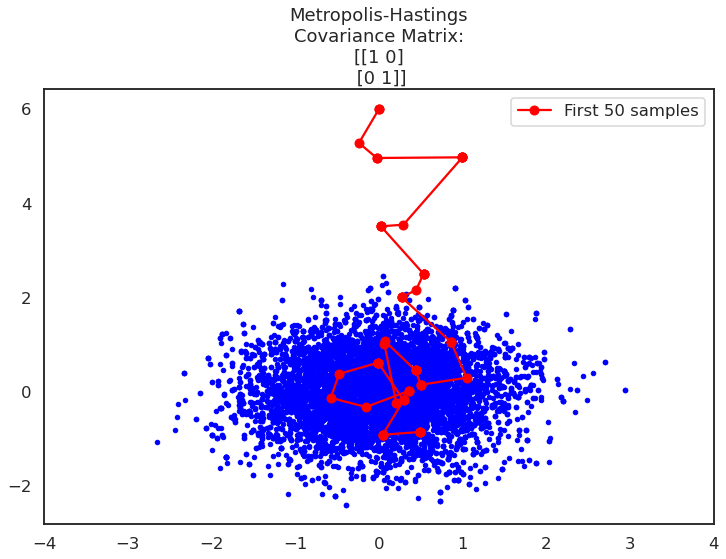

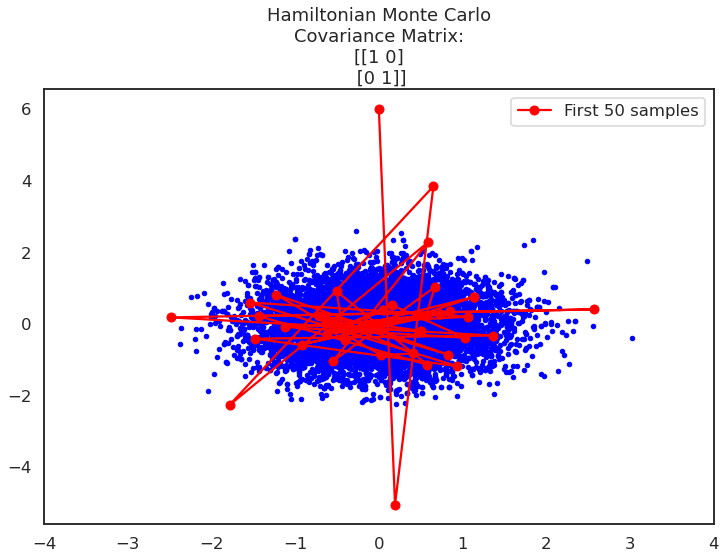

In [50]:
compare_and_plot(L = 50)

Metropolis-Hastings Acceptance Rate: 0.4071
HMC Acceptance Rate: 0.666


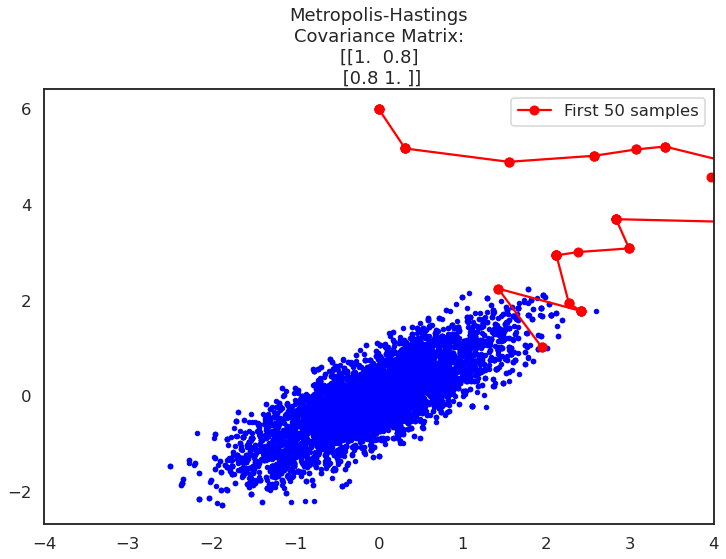

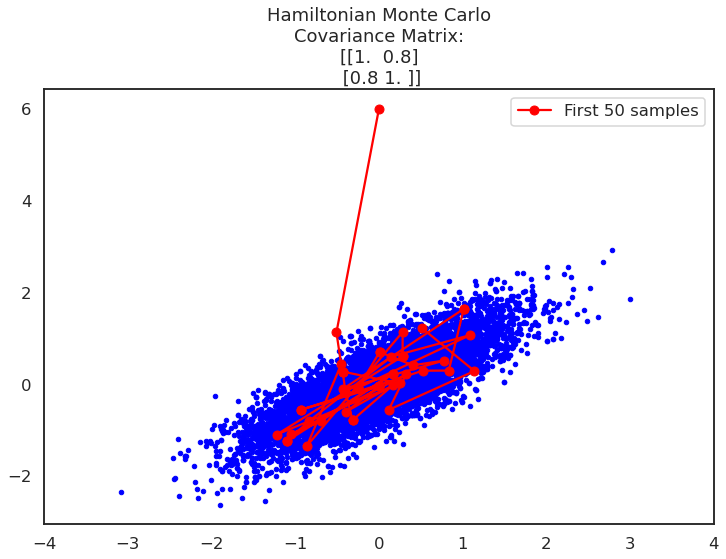

In [28]:
M = np.array([[1,0.8],[0.8,1]])
compare_and_plot(M)

Metropolis-Hastings Acceptance Rate: 0.5169
HMC Acceptance Rate: 0.690


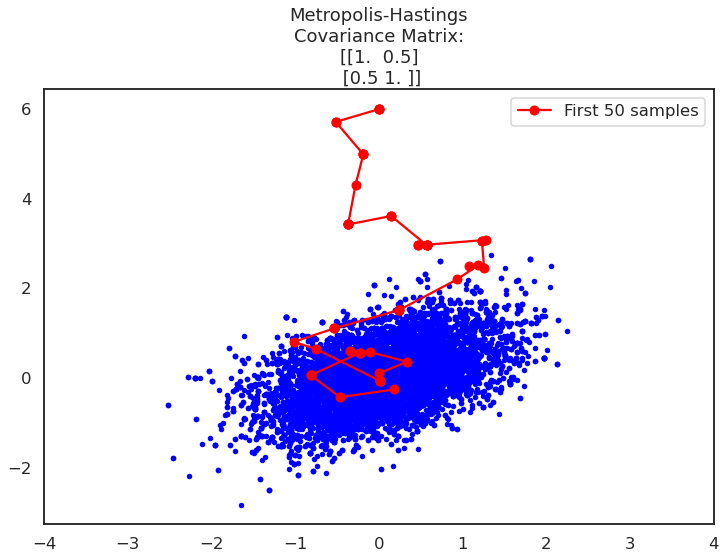

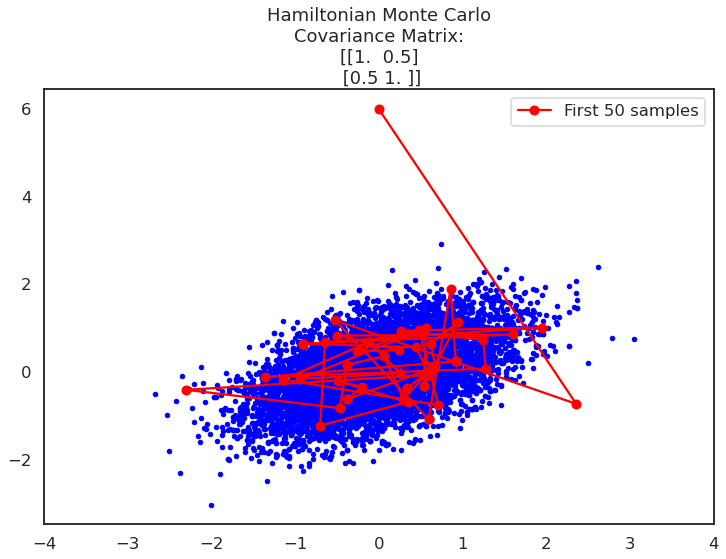

In [27]:
M = np.array([[1,0.5],[0.5,1]])
compare_and_plot(M)

Metropolis-Hastings Acceptance Rate: 0.3185
HMC Acceptance Rate: 0.649


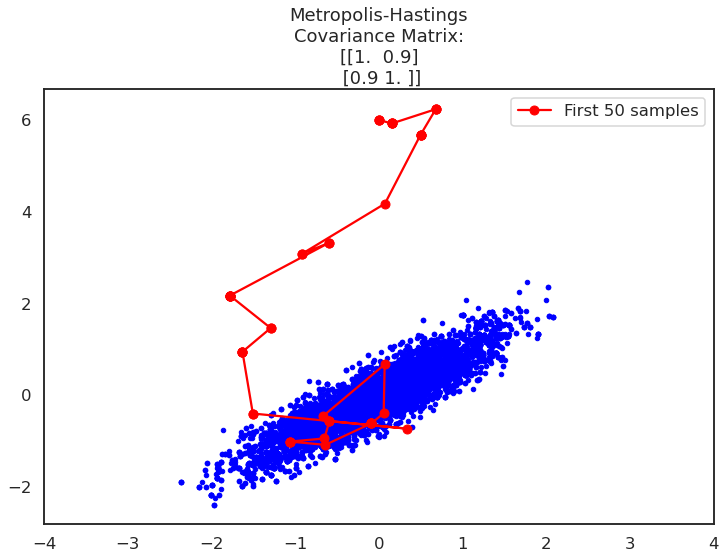

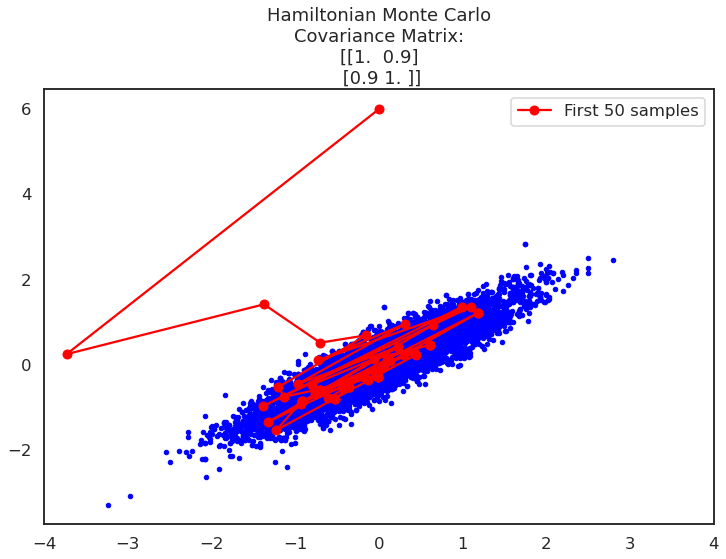

In [30]:
M = np.array([[1,0.9],[0.9,1]])
compare_and_plot(M)

Metropolis-Hastings Acceptance Rate: 0.1524
HMC Acceptance Rate: 0.000


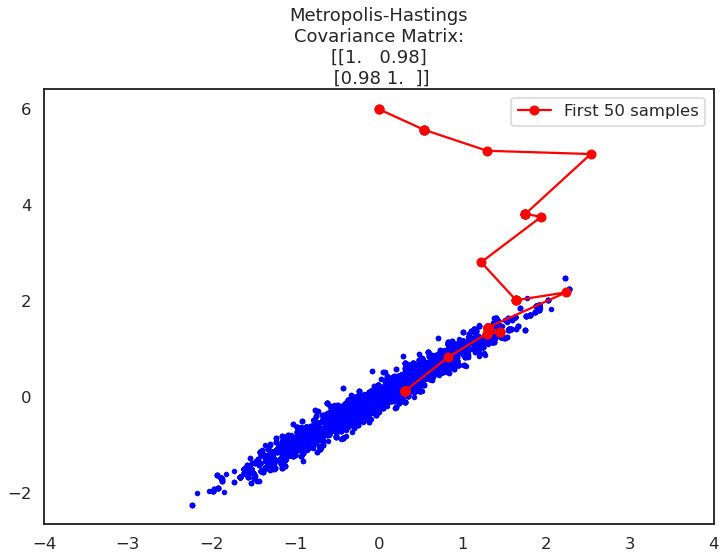

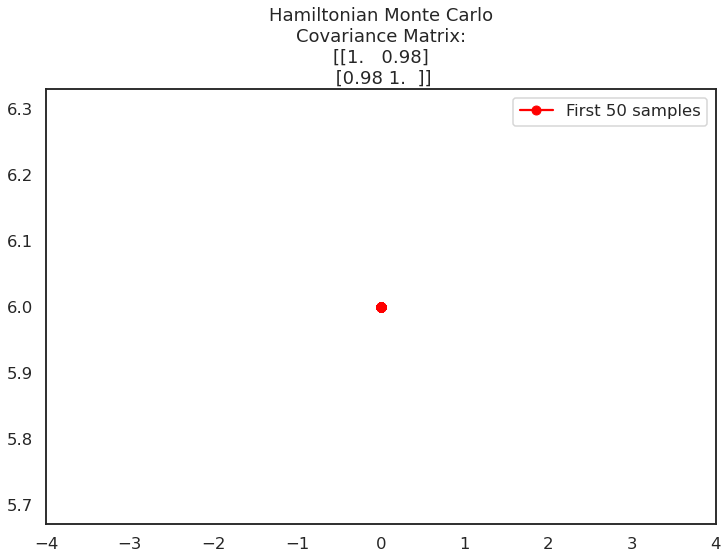

In [32]:
M = np.array([[1,0.98],[0.98,1]])
compare_and_plot(M)

Metropolis-Hastings Acceptance Rate: 0.1567
HMC Acceptance Rate: 0.000


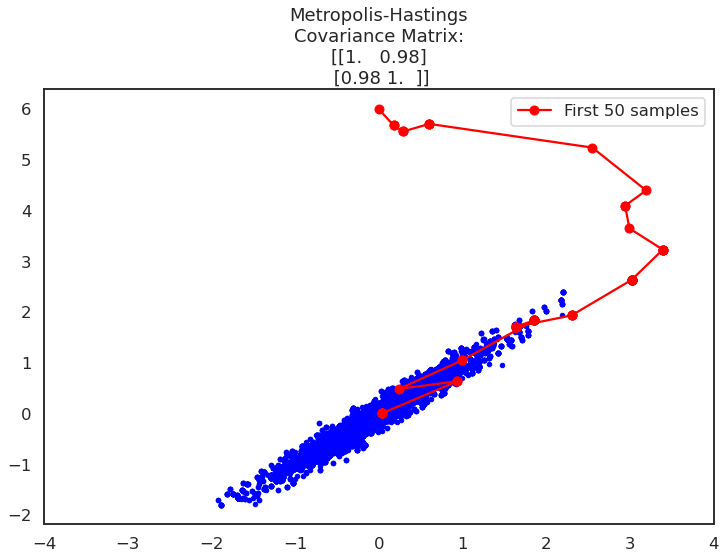

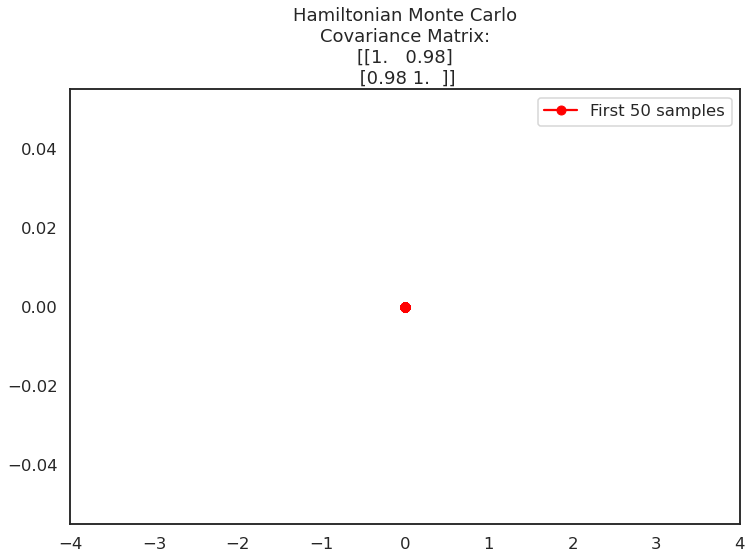

In [52]:
x0 = np.array([0,0]).T
M = np.array([[1,0.98],[0.98,1]])
compare_and_plot(M, delta = 0.0001, L = 100, x0 = x0)

In [ ]:
# Define the joint_log_prob function, and our unnormalized posterior.
def joint_log_prob(w, x, y):
  # Our model in maths is
  #   w ~ MVN([0, 0, 0], diag([1, 1, 1]))
  #   y_i ~ Normal(w @ x_i, noise_scale),  i=1..N

  rv_w = tfd.MultivariateNormalDiag(
    loc=np.zeros(2),
    scale_diag=np.ones(2))

  rv_y = tfd.Normal(f(x, w), noise_scale)
  return (rv_w.log_prob(w) +
          tf.reduce_sum(rv_y.log_prob(y), axis=-1))